In [1]:
import os
import math
import random
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import Series

from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.stattools import durbin_watson

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.statespace.varmax import VARMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [2]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [3]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [4]:
# dataset indonesia (jakarta)
case = pd.read_csv('data/new/case_maret_july.csv')
mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
case.set_index('date', inplace=True)
#weather.set_index('date', inplace=True)
mobility.set_index('date', inplace=True)

In [5]:
new_weather = weather.interpolate(method='spline', order=2)
new_weather.head()

new_weather.set_index('date', inplace=True)

In [6]:
data = pd.concat([case, new_weather, mobility], axis=1)
data.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-18,38,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
2020-03-19,50,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2020-03-20,14,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
2020-03-21,44,81.0,28.1,32.4,26.521978,-35,-5,-38,-40,-10,11
2020-03-22,36,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [7]:
data.shape

(423, 11)

In [8]:
train = data[:413]
test = data[413:]

In [9]:
model = VARMAX(train, order=(1, 2))
model_fit = model.fit(disp=False)
print(model_fit.summary())

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                                                                    Statespace Model Results                                                                                    
Dep. Variable:     ['case', 'rh', 'avt', 'mxt', 'mnt', 'retail_recreation', 'grocery_pahrmacy', 'parks', 'transit_station', 'workplace', 'residential']   No. Observations:                  413
Model:                                                                                                                                       VARMA(1,2)   Log Likelihood              -11313.493
                                                                                                                                            + intercept   AIC                          23506.986
Date:                                                                                                                                  Tue, 24 Aug 2021   BIC                          25277.303
Time:                              

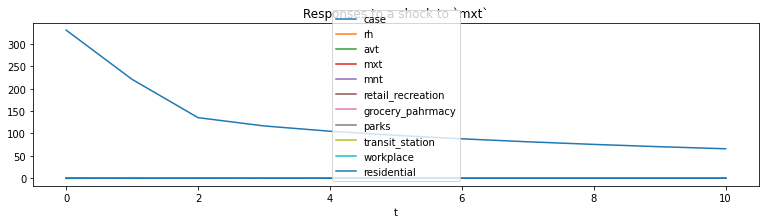

In [10]:
ax = model_fit.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `mxt`');

In [11]:
hasil = model_fit.forecast(10)

In [12]:
list_hasil = hasil['case'].tolist()
list_eval = test['case'].tolist()

In [13]:
rms = mean_squared_error(list_eval, list_hasil, squared=False)
rms

314.86539020976863

In [14]:
mse = mean_squared_error(list_eval, list_hasil)
mse

99140.21395194986

In [15]:
mae = mean_absolute_error(list_eval, list_hasil)
mae

270.285405758562